# Classifying CIFAR10 images using ResNets, Regularization and Data Augmentation in PyTorch

In [40]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Preparing the CIFAR10 Dataset
Download the dataset and create PyTorch datasets to load the data

In [41]:
CIFAR10_folder_archive = Path('.')/'data'/'CIFAR10'/'archive'
CIFAR10_folder_raw = Path('.')/'data'/'CIFAR10'/'raw'

if not (CIFAR10_folder_archive).exists():
    CIFAR10_folder_archive.mkdir(parents=True)
    
if not (CIFAR10_folder_raw).exists():
    CIFAR10_folder_raw.mkdir(parents=True)

In [42]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(
    url=dataset_url,
    root=str(CIFAR10_folder_archive)
)

Using downloaded and verified file: data\CIFAR10\archive\cifar10.tgz


In [43]:
# Extract from archive
def extract_tarfile(tar_path, out_path, force=False):
    if not any(out_path.iterdir()) or force:
        with tarfile.open(tar_path, 'r:gz') as tar:
            tar.extractall(path=out_path)

extract_tarfile(
    tar_path = CIFAR10_folder_archive/'./cifar10.tgz',
    out_path = CIFAR10_folder_raw
)

Check the folders of images

In [44]:
print([folder.name for folder in (CIFAR10_folder_raw/'cifar10').iterdir()])
print([folder.name for folder in (CIFAR10_folder_raw/'cifar10'/'test').iterdir()])
print([folder.name for folder in (CIFAR10_folder_raw/'cifar10'/'train').iterdir()])

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Images in train folder

In [45]:
for folder in (CIFAR10_folder_raw/'cifar10'/'train').iterdir():
    print(f'{folder.name} elements: {len(list(folder.iterdir()))}')

airplane elements: 5000
automobile elements: 5000
bird elements: 5000
cat elements: 5000
deer elements: 5000
dog elements: 5000
frog elements: 5000
horse elements: 5000
ship elements: 5000
truck elements: 5000


Images in test folder

In [46]:
for folder in (CIFAR10_folder_raw/'cifar10'/'test').iterdir():
    print(f'{folder.name} elements: {len(list(folder.iterdir()))}')

airplane elements: 1000
automobile elements: 1000
bird elements: 1000
cat elements: 1000
deer elements: 1000
dog elements: 1000
frog elements: 1000
horse elements: 1000
ship elements: 1000
truck elements: 1000


Create training and validation datasets using the `ImageFolder` class from `torchvision`. In addition to the `ToTensor` transform, apply some other transforms to the images
1. **Use test set for validation**: instead of setting aside a fraction (e.g. 10%) of the data from the training set for validation, simply use the test set as validation set. In general, once the best model architecture and hypeparameters have been picked using a fixed validation se, retrain the same model on the entire dataset
2. **Channel-wise data normalization**: normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result, the mean of the data across each channel is 0, and standard deviation is 1. Normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training, simply by having a higher or wider range of values that others

<img src="https://i.imgur.com/LYxXBVg.png" width="360">

3. **Randomized data augmentations**: apply randomly chosen transformations while loading images from the training dataset. Specifically,
- pad each image by 4 pixels
- take a random crop of size 32 x 32 pixels 
- flip the image horizontally with a 50% probability. 

Since the transformation will be applied randomly and dynamically each time a particular image is loaded, the model sees slightly different images in each epoch of training, which allows it generalize better.

![data-augmentation](https://imgaug.readthedocs.io/en/latest/_images/cropandpad_percent.jpg)

Multiple transformations can be applied in sequence using the [`compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html) function


The values for the normalization can be extracted from the whole dataset, computing mean and standard deviation on each channel tensor (red, green, blue)

In [47]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

Apply a sequence of transformations, such as
- [`RandomCrop`](https://pytorch.org/vision/main/generated/torchvision.transforms.RandomCrop.html): crop the given image at a random location
- [`RandomHorizontalFlip`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html): horizontally flip the given image randomly with a given probability
- [`RandomRotation`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomRotation.html): randomly rotate the image by angle
- [`ColorJitter`](https://pytorch.org/vision/main/generated/torchvision.transforms.ColorJitter.html): randomly change the brightness, contrast, saturation and hue of an image
- [`Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html): normalize (each channel of) a tensor image with mean and standard deviation

For a thorough list of image tensor trasforms available in PyTorch, see [Transforming and augmenting images](https://pytorch.org/vision/stable/transforms.html)

In [48]:
# train dataset preprocessing
train_tfms = tt.Compose([
    tt.RandomCrop(32, padding=4, padding_mode='reflect'),
    tt.RandomHorizontalFlip(),
    # tt.RandomRotation()
    # tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)),
    # tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
    tt.ToTensor(), # 
    tt.Normalize(*stats,inplace=True)
])

# test dataset preprocessing
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

The directory structure is one folder per class, and it is widly used in computer vision datasets. Most deep learning libraries provide utilites for working with such datasets. PyTorch implements the `ImageFolder` class from `torchvision` to load the data as tensors.

One of `ImageFolder` parameters is `transform`, that allows to apply a series of transformations to the images while PyTorch loads them.

In [49]:
# PyTorch datasets
train_ds = ImageFolder(
    root=str(CIFAR10_folder_raw/'cifar10'/'train'), 
    transform=train_tfms
)

valid_ds = ImageFolder(
    root=str(CIFAR10_folder_raw/'cifar10'/'test'),
    transform=valid_tfms
)

Create the data loaders for retrieving images in batches. Use a batch size of 500 to utlize a larger portion of the GPU RAM. Try reducing the batch size & restarting the kernel if "out of memory" error.

In [50]:
batch_size = 400

# PyTorch data loaders
train_dl = DataLoader(
    train_ds, 
    batch_size, 
    shuffle=True, 
    num_workers=3, 
    pin_memory=True
)

valid_dl = DataLoader(
    valid_ds, 
    batch_size*2, 
    num_workers=3, 
    pin_memory=True
)

Look at some sample images from the training dataloader. To display the images, _denormalize_ the pixels values to bring them back into the range `(0,1)`.

In [51]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        # ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break

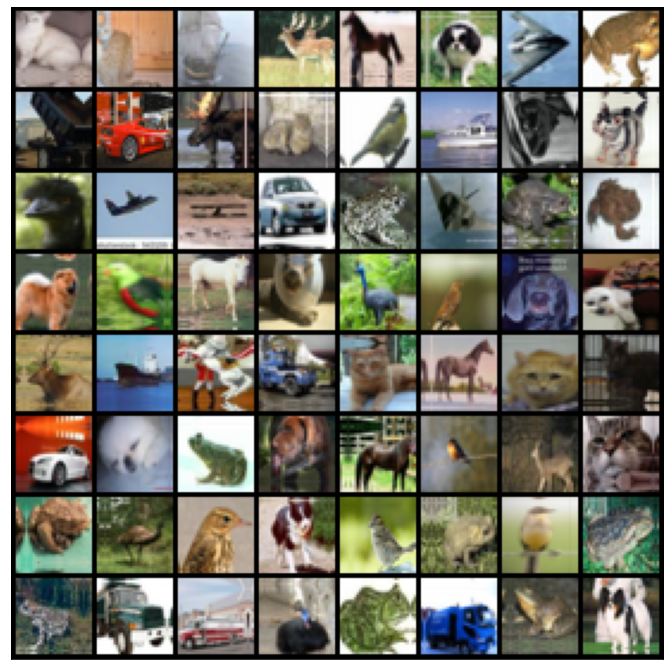

In [52]:
show_batch(train_dl)

The colors seem out of place because of the normalization; it is possible to notice the cropping and reflection padding in some of the images.

## Using a GPU

To use a GPU, if available, define the helper functions (`get_default_device` & `to_device`) and the helper class `DeviceDataLoader` to move model and data to the GPU as required.

In [53]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cuda')

Wrap training and validation data loaders using `DeviceDataLoader`

In [54]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model with Residual Blocks and Batch Normalization

Add a **residual block**, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.

![](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [55]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [56]:
simple_resnet = to_device(SimpleResidualBlock(), device)

for images, labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break
    
del simple_resnet, images, labels
torch.cuda.empty_cache()

torch.Size([400, 3, 32, 32])


Inserting a residual block produces a drastic improvement in the performance of the model. 

After each convolutional layer, add a batch normalization layer, which normalizes the outputs of the previous layer. 

See the following blog posts:

* Why and how residual blocks work: [Residual blocks — Building blocks of ResNet](https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec)
* Batch normalization and dropout explained: [Batch Normalization and Dropout in Neural Networks with Pytorch](https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd)

![resnet-9](https://github.com/lambdal/cifar10-fast/raw/master/net.svg?sanitize=true)

In [57]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) # consider the prediction with highest probability
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    # validation on batches
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    # validation at the end of epoch
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [58]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [59]:
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

## Training the model

Create a `fit` function, with

- **Learning rate scheduling**: use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, use the one called **"One Cycle Learning Rate Policy"**, which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs. Learn more: https://sgugger.github.io/the-1cycle-policy.html

- **Weight decay**: use weight decay, which is a regularization technique that prevents the weights from becoming too large by adding an additional term to the loss function. Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

- **Gradient clipping**: limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values. This simple and effective technique is called gradient clipping. Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48


Define a `fit_one_cycle` function to incorporate these changes. Record the learning rate used for each batch.

In [60]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):

        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

Notice some functions and classes:
- `torch.cuda.empty_cache()`
    > Releases all unoccupied cached memory currently held by the caching allocator so that those can be used in other GPU application and visible in nvidia-smi. ([source](https://pytorch.org/docs/stable/generated/torch.cuda.empty_cache.html))
- `torch.optim.lr_scheduler.OneCycleLR`
    > Sets the learning rate of each parameter group according to the 1cycle learning rate policy. The 1cycle policy anneals the learning rate from an initial learning rate to some maximum learning rate and then from that maximum learning rate to some minimum learning rate much lower than the initial learning rate. ([source](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html))

In [61]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3043148517608643, 'val_acc': 0.11153845489025116}]

Set the parameters

In [62]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

Run the model

In [63]:
%%time
history += fit_one_cycle(
    epochs=epochs, 
    max_lr=max_lr, 
    model=model, 
    train_loader=train_dl, 
    val_loader=valid_dl, 
    grad_clip=grad_clip, 
    weight_decay=weight_decay, 
    opt_func=opt_func
)

Epoch [0], last_lr: 0.00393, train_loss: 1.4846, val_loss: 1.4630, val_acc: 0.5324
Epoch [1], last_lr: 0.00935, train_loss: 1.0819, val_loss: 1.1061, val_acc: 0.6336
Epoch [2], last_lr: 0.00972, train_loss: 0.8333, val_loss: 1.2676, val_acc: 0.6138
Epoch [3], last_lr: 0.00812, train_loss: 0.6310, val_loss: 0.7879, val_acc: 0.7383
Epoch [4], last_lr: 0.00556, train_loss: 0.5054, val_loss: 0.5482, val_acc: 0.8138
Epoch [5], last_lr: 0.00283, train_loss: 0.3972, val_loss: 0.4385, val_acc: 0.8513
Epoch [6], last_lr: 0.00077, train_loss: 0.2955, val_loss: 0.3252, val_acc: 0.8888
Epoch [7], last_lr: 0.00000, train_loss: 0.2208, val_loss: 0.2855, val_acc: 0.9030
CPU times: total: 58.4 s
Wall time: 5min 12s


## Results
Plot the valdation set accuracies

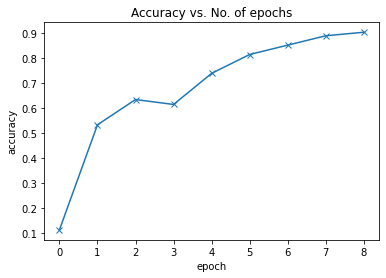

In [65]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

plot_accuracies(history)

Plot the training and validation losses

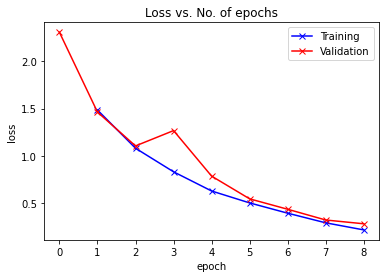

In [66]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

plot_losses(history)

Visualize how the learning rate changed over time, batch-by-batch over all the epochs

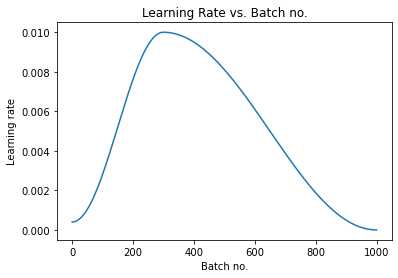

In [67]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

plot_lrs(history)

1. the learning rate starts at a low value
2. gradually increases for 30% of the iterations to a maximum value of `0.01`
3. gradually decreases to a very small value

## Testing with individual images

Look at model's results on some sample images

In [69]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: dog , Predicted: dog


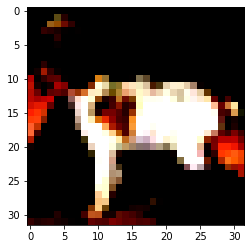

In [74]:
img, label = valid_ds[5000]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))